In [4]:
%pip install scikit-image --quiet
%pip install tensorly --quiet
n = 10
nq = 5
thresholds = 0.25
contrast = 95
tol = 7


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


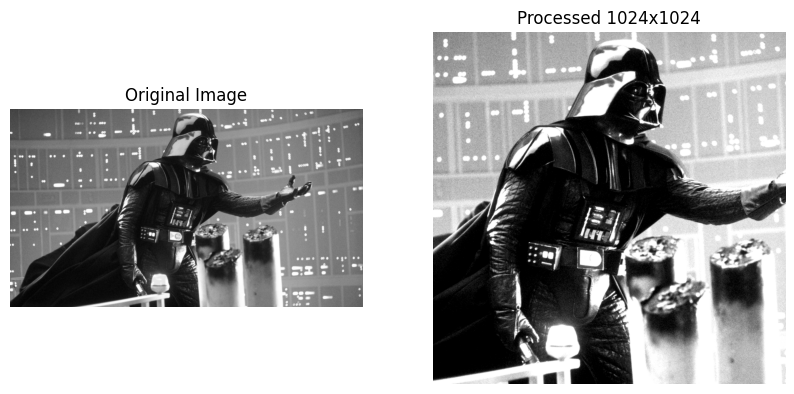

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.transform import resize
import gc
import tensorly as tl
from tensorly.decomposition import tensor_train
from scipy.signal import convolve2d

# Load a grayscale image (or convert to grayscale)
img = Image.open('/workspaces/AQA/images/Edge-Test-4.jpg').convert('L')
arr = np.array(img, dtype=np.float32) / 255.0  # Use float32 to save memory
contrast_low = 100-contrast    # Lower percentile for initial stretch
contrast_high = contrast  # Upper percentile for initial stretch
final_low = contrast_low+tol     # Lower percentile for final stretch
final_high = contrast_high-tol    # Upper percentile for final stretch

# Contrast stretching in-place
p2, p98 = np.percentile(arr, (contrast_low, contrast_high))
arr[:] = np.interp(arr, (p2, p98), (0, 1))

# Edge-preserving enhancement in-place
blurred = gaussian_filter(arr, sigma=0.5)
arr += 0.8 * (arr - blurred)
np.clip(arr, 0, 1, out=arr)

# Resize (float32)
# Crop to center square before resizing
h, w = arr.shape
min_side = min(h, w)
top = (h - min_side) // 2
left = (w - min_side) // 2
arr_cropped = arr[top:top+min_side, left:left+min_side]

# Resize (float32)
arr = resize(arr_cropped, (2**n, 2**n), order=3, anti_aliasing=False, mode='reflect').astype(np.float32)

# Final contrast adjustment in-place
p5, p95 = np.percentile(arr, (final_low, final_high))
arr[:] = np.interp(arr, (p5, p95), (0, 1))
# Display the processed input image
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(np.array(img), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(arr, cmap='gray')
plt.title('Processed {}x{}'.format(2**n, 2**n))
plt.axis('off')
plt.show()

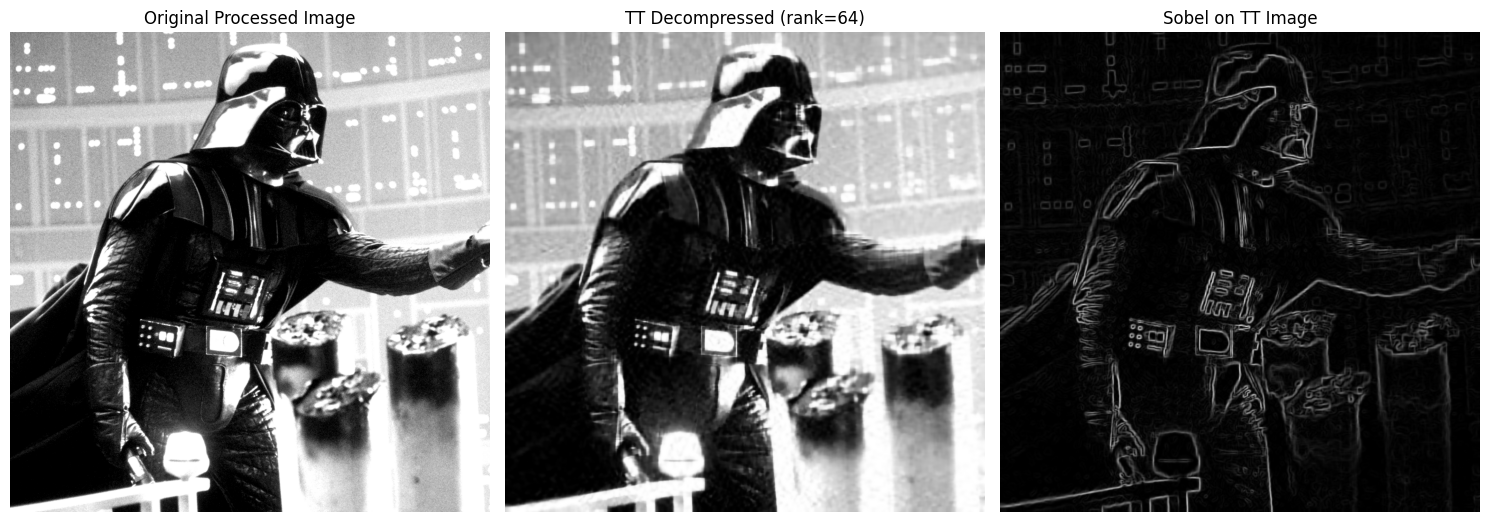

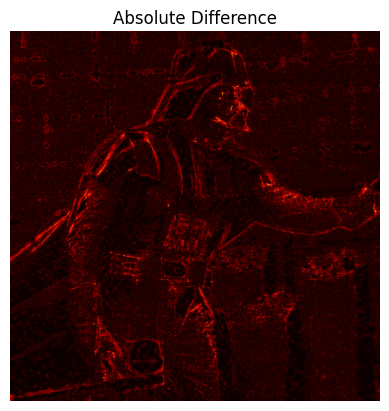

8767

In [6]:
import tensorly as tl
from tensorly.decomposition import tensor_train
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from skimage.restoration import denoise_tv_chambolle

# 1. Tensor Train Decomposition (compression)
tt_rank = 64  # You can try 8, 16, or 32; higher = better quality, more memory
arr_for_tt = gaussian_filter(arr, sigma=0.5)
tt = tensor_train(arr_for_tt, rank=tt_rank)

# 2. Reconstruct (decompress) the image from the TT format
# After TT decompression
arr_tt = tl.tt_to_tensor(tt)
arr_tt = np.clip(arr_tt, 0, 1)
arr_tt = arr_tt + 0.5 * (arr_tt - gaussian_filter(arr_tt, sigma=1))
arr_tt = np.clip(arr_tt, 0, 1)
arr_tt = denoise_tv_chambolle(arr_tt, weight=0.05)
arr_tt = (arr_tt - arr_tt.min()) / (arr_tt.max() - arr_tt.min())
# 3. Apply Sobel filter to the decompressed image
Gx = np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
Gy = np.array([[1, 2,  1],[0,0, 0],[-1,-2,-1]])
sobel_input = gaussian_filter(arr_tt, sigma=0.7)
gx_tt = convolve2d(sobel_input, Gx, mode='same', boundary='symm')
gy_tt = convolve2d(sobel_input, Gy, mode='same', boundary='symm')
sobel_tt = np.hypot(gx_tt, gy_tt)


# 4. Display results
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.imshow(arr, cmap='gray')
plt.title('Original Processed Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(arr_tt, cmap='gray')
plt.title(f'TT Decompressed (rank={tt_rank})')
plt.axis('off')

plt.subplot(133)
plt.imshow(sobel_tt, cmap='gray')
plt.title('Sobel on TT Image')
plt.axis('off')
plt.tight_layout()
plt.figure()
plt.imshow(np.abs(arr - arr_tt), cmap='hot')
plt.title('Absolute Difference')
plt.axis('off')
plt.show()
# Optional: free memory
del tt, arr_tt, gx_tt, gy_tt, sobel_tt
import gc
gc.collect()